# json 패턴 일치 확인

In [2]:
import json
from pathlib import Path
from collections import Counter

root_dir = Path("E:/데이터/감정태깅/134-1.감정이 태깅된 자유대화 (성인)/01-1.정식개방데이터/Training")  # 실내 or 실외 경로
data_dir= root_dir / "02.라벨링데이터" / "실내"
json_files = list(data_dir.glob("*.json"))

# key 패턴 수집
key_sets = []
for jf in json_files[:100]:  # 샘플 100개만 확인해도 충분
    with open(jf, encoding="utf-8") as f:
        data = json.load(f)
        key_sets.append(tuple(sorted(data.keys())))

print(Counter(key_sets))

Counter({('Conversation', 'ConversationInfo', 'File', 'Noise', 'Speaker1', 'Speaker2', 'Wav'): 100})


In [3]:
from collections import Counter, defaultdict
from typing import Any

# === 설정 ===
ROOT = Path(r"E:/데이터/감정태깅/134-1.감정이 태깅된 자유대화 (성인)/01-1.정식개방데이터/Training")
LABEL_DIRS = [ROOT / "02.라벨링데이터" / "실내", ROOT / "02.라벨링데이터" / "실외"]
SAMPLE_PER_ENV = 200  # 환경별 샘플 최대 개수 (과하면 느려질 수 있음)
LIST_SAMPLE_LIMIT = 5  # 리스트 내부 샘플링 개수
EXAMPLE_LIMIT = 3      # 예시 값 저장 최대 개수
PRINT_LIMIT = 120      # 콘솔 출력 줄수 제어용(필요시 조절)

# === 유틸 ===
def short_repr(v: Any, maxlen: int = 80) -> str:
    try:
        s = repr(v)
    except Exception:
        s = f"<{type(v).__name__}>"
    if len(s) > maxlen:
        s = s[:maxlen-3] + "..."
    return s

def typename(v: Any) -> str:
    if v is None: return "null"
    t = type(v)
    if t is dict: return "object"
    if t is list: return "array"
    if t in (str, int, float, bool): return t.__name__
    return t.__name__

# 경로별 타입/예시를 수집하는 트래버서
class SchemaCollector:
    def __init__(self):
        self.type_counter = defaultdict(Counter)     # path -> Counter({type:count})
        self.examples = defaultdict(list)            # path -> [example values]
        self.object_keysets = defaultdict(Counter)   # path(=object 노드) -> Counter of frozenset(keys)
        self.array_len_stats = Counter()             # path -> count of observed lengths

    def add_example(self, path: str, v: Any):
        ex = short_repr(v)
        arr = self.examples[path]
        if ex not in arr and len(arr) < EXAMPLE_LIMIT:
            arr.append(ex)

    def walk(self, obj: Any, base: str = "$"):
        tname = typename(obj)
        self.type_counter[base][tname] += 1

        # 예시: 원시타입/널만 붙임
        if tname not in ("object", "array"):
            self.add_example(base, obj)
            return

        if tname == "object":
            keys = tuple(sorted(obj.keys()))
            self.object_keysets[base][frozenset(keys)] += 1
            for k, v in obj.items():
                self.walk(v, f"{base}.{k}")
        elif tname == "array":
            # 리스트 길이 통계
            if hasattr(obj, "__len__"):
                self.array_len_stats[base] += len(obj)
            # 리스트 원소 샘플링
            for i, v in enumerate(obj[:LIST_SAMPLE_LIMIT]):
                self.walk(v, f"{base}[]")

def collect_json_paths(files):
    collector = SchemaCollector()
    top_keysets = Counter()
    for jf in files:
        try:
            with open(jf, encoding="utf-8") as f:
                data = json.load(f)
        except Exception as e:
            print(f"[WARN] JSON load fail: {jf} ({e})")
            continue

        # 최상위 키 조합
        if isinstance(data, dict):
            top_keysets[tuple(sorted(data.keys()))] += 1
        collector.walk(data, "$")
    return collector, top_keysets

def peek_conversation_items(files, conv_key="Conversation"):
    """
    Conversation 항목(리스트)의 아이템 스키마/누락 필드 점검.
    예상 필드: start, end, emotion, speaker, text 등 (존재시 집계)
    """
    item_keyset = Counter()
    present_counts = Counter()
    total_items = 0

    # 필드 존재여부를 보고싶은 후보 키들
    must_have_candidates = ["start", "end", "emotion", "speaker", "text", "label", "role", "start_ms", "end_ms"]

    for jf in files:
        try:
            with open(jf, encoding="utf-8") as f:
                data = json.load(f)
        except Exception:
            continue

        conv = data.get(conv_key)
        if not isinstance(conv, list): 
            continue

        for item in conv[:10000]:  # 파일당 상한 (안전장치)
            if not isinstance(item, dict):
                continue
            total_items += 1
            keys = tuple(sorted(item.keys()))
            item_keyset[keys] += 1
            # 존재여부 카운트
            for k in must_have_candidates:
                if k in item and item[k] not in (None, ""):
                    present_counts[k] += 1

    # 누락(= total - present)
    missing = {k: total_items - present_counts.get(k, 0) for k in must_have_candidates}
    return {
        "total_items": total_items,
        "item_keyset": item_keyset,
        "present_counts": present_counts,
        "missing_counts": missing,
    }

# === 실행 ===
all_files = []
for d in LABEL_DIRS:
    if d.exists():
        js = sorted(d.glob("*.json"))
        all_files.extend(js[:SAMPLE_PER_ENV])

print(f"[INFO] 분석 대상 JSON 파일 수: {len(all_files)} (실내/실외 샘플 병합)")

collector, top_keysets = collect_json_paths(all_files)
conv_report = peek_conversation_items(all_files, conv_key="Conversation")

# === 출력 ===
def print_counter(title, c: Counter, limit=10, fmt=lambda k: k):
    print(f"\n## {title}")
    for i, (k,v) in enumerate(c.most_common()):
        if i >= limit:
            print(f"... (+{len(c)-limit} more)")
            break
        print(f"{fmt(k)} : {v}")

# 1) 최상위 키 조합
print_counter("Top-level keyset distribution", top_keysets, limit=10, fmt=lambda k: ", ".join(k))

# 2) 계층형 스키마(일부만 표시)
print("\n## Field path → type(s) [example]")
shown = 0
for path, tcount in sorted(collector.type_counter.items()):
    typestr = "/".join(f"{t}:{n}" for t, n in tcount.most_common())
    ex = f"  e.g. {collector.examples[path]}" if collector.examples.get(path) else ""
    print(f"{path} -> {typestr}{ex}")
    shown += 1
    if shown >= PRINT_LIMIT:
        print("... (truncated)")
        break

# 3) object 노드의 키셋 분포(상위 5개 경로만)
print("\n## Object keysets by path (top 5 paths)")
obj_paths_sorted = sorted(collector.object_keysets.items(), key=lambda kv: sum(kv[1].values()), reverse=True)[:5]
for base, dist in obj_paths_sorted:
    print(f"\n[Object path] {base}")
    cnt = 0
    for keyset, n in dist.most_common():
        print(f"  keys=({', '.join(sorted(keyset))}) : {n}")
        cnt += 1
        if cnt >= 5:
            print("  ...")
            break

# 4) 배열 길이 대략(평균)
if collector.array_len_stats:
    print("\n## Array length (rough totals)")
    for path, total_len in collector.array_len_stats.items():
        print(f"{path}: total_elems≈{total_len} (over observed arrays)")

# 5) Conversation 항목 리포트
print("\n## Conversation item schema")
print(f"- total items: {conv_report['total_items']}")
print_counter("Conversation item keyset distribution", conv_report["item_keyset"], limit=10, fmt=lambda k: ", ".join(k))
print("\n- Field presence counts (top):")
for k, v in conv_report["present_counts"].most_common():
    print(f"  {k}: {v}")
print("\n- Field missing counts (key candidates):")
for k, v in conv_report["missing_counts"].items():
    print(f"  {k}: missing {v}")

# === (옵션) 빠른 무결성 체크 포인트 ===
# - 시간 구간(start<end) 위반, 음수, 중복/겹침 등은 다음 단계에서 별도 함수로 점검 예정.
# - 필요 시, Conversation[]에서 start/end가 'ms'인지 'sec'인지 스케일 추정도 추가 가능.

[INFO] 분석 대상 JSON 파일 수: 400 (실내/실외 샘플 병합)

## Top-level keyset distribution
Conversation, ConversationInfo, File, Noise, Speaker1, Speaker2, Wav : 400

## Field path → type(s) [example]
$ -> object:400
$.Conversation -> array:400
$.ConversationInfo -> object:400
$.ConversationInfo.Domain -> str:400  e.g. ["'취미'", "'생활'", "'경제/사회'"]
$.ConversationInfo.Step1Subject -> str:400  e.g. ["'문화생활'", "'여행/숙박'", "'자산관리/경제활동'"]
$.ConversationInfo.Step2Subject -> str:400  e.g. ["'독서'", "'국내여행'", "'해외여행'"]
$.Conversation[] -> object:1991
$.Conversation[].EndTime -> str:1991  e.g. ["'3.50'", "'4.33'", "'5.57'"]
$.Conversation[].SpeakerEmotionCategory -> str:1991  e.g. ["'긍정'", "'중립'", "'부정'"]
$.Conversation[].SpeakerEmotionLevel -> str:1991  e.g. ["'보통'", "'약함'", "'강함'"]
$.Conversation[].SpeakerEmotionObject -> str:1991  e.g. ["'1'", "'2'", "'0'"]
$.Conversation[].SpeakerEmotionTarget -> str:1991  e.g. ["'기쁨'", "'놀라움'", "'없음'"]
$.Conversation[].SpeakerNo -> str:1991  e.g. ["'Speaker1'", "'Speaker2'"]

In [4]:
from collections import Counter, defaultdict
import json

def peek_conversation_items_v2(files, conv_key="Conversation", alias=None, nonempty=lambda v: v not in (None, "", "''")):
    """
    Conversation 리스트의 아이템을 훑어보며
    - 표준화 키(예: start/end/speaker/text/emotion_*) 기준 존재 카운트
    - 실제 어떤 원본 키가 쓰였는지 분해
    - 키셋 분포
    를 리턴합니다.
    """
    # 1) 표준화 키 → 원본 키 후보(aliase) 정의
    if alias is None:
        alias = {
            "start":            ["StartTime", "start", "BeginTime", "start_ms"],
            "end":              ["EndTime", "end", "End", "end_ms"],
            "speaker":          ["SpeakerNo", "speaker", "role", "Speaker"],
            "text":             ["Text", "text", "utterance"],
            "emotion_category": ["VerifyEmotionCategory", "SpeakerEmotionCategory", "EmotionCategory", "emotion_cat"],
            "emotion_target":   ["VerifyEmotionTarget", "SpeakerEmotionTarget", "EmotionTarget", "emotion", "label"],
            "emotion_level":    ["VerifyEmotionLevel", "SpeakerEmotionLevel", "EmotionLevel"],
            "utt_id":           ["TextNo", "utt_id", "id"],
        }

    item_keyset = Counter()
    present_counts = Counter()
    used_key_breakdown = {k: Counter() for k in alias.keys()}
    examples = defaultdict(list)
    total_items = 0

    def add_example(std_key, val, limit=3):
        val_str = repr(val)
        if len(examples[std_key]) < limit and val_str not in examples[std_key]:
            examples[std_key].append(val_str)

    for jf in files:
        try:
            with open(jf, encoding="utf-8") as f:
                data = json.load(f)
        except Exception:
            continue

        conv = data.get(conv_key)
        if not isinstance(conv, list):
            continue

        for item in conv:
            if not isinstance(item, dict):
                continue
            total_items += 1
            item_keyset[tuple(sorted(item.keys()))] += 1

            # 2) 표준화 키별로 후보 키를 순서대로 검사
            for std_key, candidates in alias.items():
                for k in candidates:
                    if k in item and nonempty(item[k]):
                        present_counts[std_key] += 1
                        used_key_breakdown[std_key][k] += 1
                        add_example(std_key, item[k])
                        break  # 첫 매칭만 채택

    # 3) 누락 카운트
    missing = {k: total_items - present_counts.get(k, 0) for k in alias.keys()}

    return {
        "total_items": total_items,
        "item_keyset": item_keyset,
        "present_counts": present_counts,
        "missing_counts": missing,
        "used_key_breakdown": used_key_breakdown,
        "examples": examples,
    }





In [5]:
conv_report = peek_conversation_items_v2(all_files, conv_key="Conversation")
print("total:", conv_report["total_items"])
print("\n[표준화 키 존재 카운트]")
for k, v in conv_report["present_counts"].most_common():
    print(f"  {k:>17s}: {v}")
print("\n[누락 카운트]")
for k, v in conv_report["missing_counts"].items():
    print(f"  {k:>17s}: missing {v}")
print("\n[원본 키 사용 분해(상위)]")
for std_key, br in conv_report["used_key_breakdown"].items():
    if sum(br.values()) == 0: 
        continue
    top = br.most_common(3)
    print(f"  {std_key:>17s} <- {top}")
print("\n[예시 값]")
for std_key, ex in conv_report["examples"].items():
    print(f"  {std_key:>17s}: {ex}")

total: 125590

[표준화 키 존재 카운트]
              start: 125590
                end: 125590
            speaker: 125590
               text: 125590
   emotion_category: 125590
     emotion_target: 125590
      emotion_level: 125590
             utt_id: 125590

[누락 카운트]
              start: missing 0
                end: missing 0
            speaker: missing 0
               text: missing 0
   emotion_category: missing 0
     emotion_target: missing 0
      emotion_level: missing 0
             utt_id: missing 0

[원본 키 사용 분해(상위)]
              start <- [('StartTime', 125590)]
                end <- [('EndTime', 125590)]
            speaker <- [('SpeakerNo', 125590)]
               text <- [('Text', 125590)]
   emotion_category <- [('VerifyEmotionCategory', 125590)]
     emotion_target <- [('VerifyEmotionTarget', 125590)]
      emotion_level <- [('VerifyEmotionLevel', 125590)]
             utt_id <- [('TextNo', 125590)]

[예시 값]
              start: ["'2.29'", "'2.98'", "'5.04'"]
             

In [6]:
import pandas as pd
from typing import Optional

# ==== 경로 설정 ====
ROOT = Path(r"E:/데이터/감정태깅/134-1.감정이 태깅된 자유대화 (성인)/01-1.정식개방데이터/Training")
LABEL_DIR = ROOT / "02.라벨링데이터" / "실내"      # 실내만 처리
AUDIO_DIR = ROOT / "01.원천데이터" / "실내"        # wav 매칭용
OUT_PARQUET = Path("conversation_indoor.parquet")   # 권장 출력
OUT_CSV = None                                      # CSV도 필요하면 경로 지정: Path("conversation_indoor.csv")

# ==== 유틸 ====
def match_wav_path(stem: str) -> Optional[str]:
    """json stem과 동일한 wav 파일 경로 추정"""
    p = AUDIO_DIR / f"{stem}.wav"
    return str(p) if p.exists() else None

def safe_get(d, path, default=None):
    """중첩 dict에서 'A.B' 경로 안전 접근"""
    cur = d
    for key in path.split("."):
        if not isinstance(cur, dict) or key not in cur:
            return default
        cur = cur[key]
    return cur

def load_one_json(json_path: Path) -> list[dict]:
    """한 JSON → Conversation 행 리스트(비정규화)"""
    with open(json_path, encoding="utf-8") as f:
        data = json.load(f)

    file_meta = data.get("File", {})
    wav_meta  = data.get("Wav", {})
    noise     = data.get("Noise", {})
    spk1      = data.get("Speaker1", {})
    spk2      = data.get("Speaker2", {})
    conv      = data.get("Conversation", [])
    convinfo  = data.get("ConversationInfo", {})

    stem = json_path.stem
    wav_path = match_wav_path(stem)

    rows = []
    for item in conv:
        row = {}

        # ---- 원본 Conversation 핵심 ----
        for k in ["TextNo","StartTime","EndTime","SpeakerNo","Text",
                  "VerifyEmotionCategory","VerifyEmotionTarget","VerifyEmotionLevel",
                  "SpeakerEmotionCategory","SpeakerEmotionTarget","SpeakerEmotionLevel"]:
            row[k] = item.get(k)

        # ---- 상위 메타(접두어 보존) ----
        for prefix, meta in [
            ("File", file_meta), ("Wav", wav_meta), ("Noise", noise),
            ("Speaker1", spk1), ("Speaker2", spk2), ("ConversationInfo", convinfo),
        ]:
            for k, v in meta.items():
                row[f"{prefix}.{k}"] = v

        # ---- 경로/환경 메타 ----
        row["env"] = "실내"
        row["json_path"] = str(json_path)
        row["wav_path"]  = wav_path
        row["session_id"] = safe_get(file_meta, "FileName", stem)  # 파일명 기반 세션 ID

        rows.append(row)

    return rows

def build_df_from_dir(label_dir: Path) -> pd.DataFrame:
    all_rows = []
    json_files = sorted(label_dir.glob("*.json"))
    print(f"[INFO] 실내 JSON 파일 수: {len(json_files)}")

    for i, jp in enumerate(json_files, 1):
        try:
            rows = load_one_json(jp)
            all_rows.extend(rows)
        except Exception as e:
            print(f"[WARN] JSON 파싱 실패: {jp} ({e})")
        if i % 200 == 0:
            print(f"  - 진행 {i}/{len(json_files)}")

    df = pd.DataFrame(all_rows)
    print(f"[INFO] Conversation 행 수: {len(df)}")

    # ---- 파생 컬럼 (타입/편의) ----
    # 숫자 변환 (에러시 NaN)
    num_cols_float = ["StartTime","EndTime","File.FileLength","File.SpeechLength"]
    for c in num_cols_float:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    num_cols_int = ["Wav.SamplingRate","Wav.NumberOfChannel","Wav.NumberOfBit"]
    for c in num_cols_int:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

    # 편의 파생
    df["start"] = df["StartTime"].astype(float)
    df["end"]   = df["EndTime"].astype(float)
    df["dur"]   = df["end"] - df["start"]
    df["speaker"] = df["SpeakerNo"].map({"Speaker1": 1, "Speaker2": 2}).astype("Int64")

    df["emotion_cat"] = df["VerifyEmotionCategory"]
    df["emotion_tgt"] = df["VerifyEmotionTarget"]
    df["emotion_lvl"] = df["VerifyEmotionLevel"]

    df["file_len"]   = df.get("File.FileLength")
    df["speech_len"] = df.get("File.SpeechLength")
    df["sr"]         = df.get("Wav.SamplingRate")
    df["channels"]   = df.get("Wav.NumberOfChannel")
    df["bit"]        = df.get("Wav.NumberOfBit")

    # ---- 카테고리형 캐스팅 (메모리↓, groupby↑) ----
    cat_cols = [
        "SpeakerNo","VerifyEmotionCategory","VerifyEmotionTarget","VerifyEmotionLevel",
        "SpeakerEmotionCategory","SpeakerEmotionTarget","SpeakerEmotionLevel",
        "Speaker1.Gender","Speaker2.Gender","Speaker1.Age","Speaker2.Age",
        "Speaker1.Mask","Speaker2.Mask","Speaker1.Condition","Speaker2.Condition",
        "Speaker1.RecDevice","Speaker2.RecDevice","Speaker1.Residence","Speaker2.Residence",
        "Speaker1.Occupation","Speaker2.Occupation",
        "ConversationInfo.Domain","ConversationInfo.Step1Subject","ConversationInfo.Step2Subject",
        "env"
    ]
    for c in cat_cols:
        if c in df.columns:
            df[c] = df[c].astype("category")

    # ---- 빠른 무결성 체크 ----
    nonpos = (df["dur"] <= 0) | df["dur"].isna()
    print(f"[CHECK] 비양수 dur 행: {nonpos.sum()} / {len(df)}")

    dup_pairs = df.duplicated(subset=["session_id","TextNo"]).sum()
    print(f"[CHECK] (session_id, TextNo) 중복: {dup_pairs}")

    return df

def main():
    df = build_df_from_dir(LABEL_DIR)

    # 저장
    if OUT_PARQUET:
        df.to_parquet(OUT_PARQUET, index=False)
        print(f"[SAVE] Parquet 저장: {OUT_PARQUET} ({OUT_PARQUET.resolve()})")

    if OUT_CSV:
        # 주의: CSV는 용량 큼. 필요시만 사용.
        df.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
        print(f"[SAVE] CSV 저장: {OUT_CSV} ({OUT_CSV.resolve()})")

    # 샘플 통계 일부 출력
    print("\n=== Quick EDA ===")
    print(df["emotion_cat"].value_counts())
    print(df["dur"].describe())

if __name__ == "__main__":
    main()

[INFO] 실내 JSON 파일 수: 8306
  - 진행 200/8306
  - 진행 400/8306
  - 진행 600/8306
  - 진행 800/8306
  - 진행 1000/8306
  - 진행 1200/8306
  - 진행 1400/8306
  - 진행 1600/8306
  - 진행 1800/8306
  - 진행 2000/8306
  - 진행 2200/8306
  - 진행 2400/8306
  - 진행 2600/8306
  - 진행 2800/8306
  - 진행 3000/8306
  - 진행 3200/8306
  - 진행 3400/8306
  - 진행 3600/8306
  - 진행 3800/8306
  - 진행 4000/8306
  - 진행 4200/8306
  - 진행 4400/8306
  - 진행 4600/8306
  - 진행 4800/8306
  - 진행 5000/8306
  - 진행 5200/8306
  - 진행 5400/8306
  - 진행 5600/8306
  - 진행 5800/8306
  - 진행 6000/8306
  - 진행 6200/8306
  - 진행 6400/8306
  - 진행 6600/8306
  - 진행 6800/8306
  - 진행 7000/8306
  - 진행 7200/8306
  - 진행 7400/8306
  - 진행 7600/8306
  - 진행 7800/8306
  - 진행 8000/8306
  - 진행 8200/8306
[INFO] Conversation 행 수: 2409729
[CHECK] 비양수 dur 행: 288872 / 2409729
[CHECK] (session_id, TextNo) 중복: 0
[SAVE] Parquet 저장: conversation_indoor.parquet (D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\tests\conversation_indoor.parquet)

=== Quick EDA ===
emotion_cat
긍정    1416843
중립     591070

In [9]:
df=pd.read_parquet('conversation_indoor.parquet')

In [10]:
df.head()

,TextNo,StartTime,EndTime,SpeakerNo,Text,VerifyEmotionCategory,VerifyEmotionTarget,VerifyEmotionLevel,SpeakerEmotionCategory,SpeakerEmotionTarget,...,dur,speaker,emotion_cat,emotion_tgt,emotion_lvl,file_len,speech_len,sr,channels,bit
0,000001,2.29,3.50,Speaker1,음식을 잘 표현해야 돼요,긍정,기쁨,보통,긍정,기쁨,...,1.21,1,긍정,기쁨,보통,663.55,658.63,48000,2,16
1,000002,2.98,4.33,Speaker2,좀 돼요 후회,긍정,놀라움,약함,긍정,놀라움,...,1.35,2,긍정,놀라움,약함,663.55,658.63,48000,2,16
2,000003,5.04,5.57,Speaker2,조심한 뭐랄지,긍정,놀라움,약함,긍정,놀라움,...,0.53,2,긍정,놀라움,약함,663.55,658.63,48000,2,16
3,000004,6.49,7.16,Speaker1,벌써 시작했네,긍정,기쁨,보통,긍정,기쁨,...,0.67,1,긍정,기쁨,보통,663.55,658.63,48000,2,16
4,000005,8.50,9.28,Speaker2,안녕,중립,없음,보통,중립,없음,...,0.78,2,중립,없음,보통,663.55,658.63,48000,2,16


In [7]:
# stream_json_to_parquet.py (Python 3.9 OK)
from pathlib import Path
from typing import Optional, List, Dict, Any
import json
import pyarrow as pa
import pyarrow.parquet as pq

ROOT = Path(r"E:/데이터/감정태깅/134-1.감정이 태깅된 자유대화 (성인)/01-1.정식개방데이터/Training")
LABEL_DIR = ROOT / "02.라벨링데이터" / "실내"
AUDIO_DIR = ROOT / "01.원천데이터" / "실내"
OUT_PATH  = Path("conversation_indoor_stream.parquet")

# ---- 필요한 컬럼만 최소화해서 추출 (메모리↓) ----
BASE_ITEM_KEYS = [
    "TextNo","StartTime","EndTime","SpeakerNo","Text",
    "VerifyEmotionCategory","VerifyEmotionTarget","VerifyEmotionLevel",
]
BASE_FILE_KEYS = ["FileName","FileLength","SpeechLength","BeginOfSpeech","EndOfSpeech"]
BASE_WAV_KEYS  = ["SamplingRate","NumberOfChannel","NumberOfBit","EncodingLaw"]
BASE_NOISE_KEYS = ["Speaker1NoiseCategory","Speaker1NoiseType","Speaker1SNR",
                   "Speaker2NoiseCategory","Speaker2NoiseType","Speaker2SNR"]
BASE_SPK_KEYS   = ["Age","Gender","Mask","Condition","Occupation","RecDevice","Residence","AgeCategory","ID"]
BASE_INFO_KEYS  = ["Domain","Step1Subject","Step2Subject"]

def match_wav_path(stem: str) -> Optional[str]:
    p = AUDIO_DIR / f"{stem}.wav"
    return str(p) if p.exists() else None

def extract_rows(json_path: Path) -> List[Dict[str, Any]]:
    with open(json_path, encoding="utf-8") as f:
        d = json.load(f)

    file_meta = d.get("File", {}) or {}
    wav_meta  = d.get("Wav", {}) or {}
    noise     = d.get("Noise", {}) or {}
    spk1      = d.get("Speaker1", {}) or {}
    spk2      = d.get("Speaker2", {}) or {}
    convinfo  = d.get("ConversationInfo", {}) or {}
    conv      = d.get("Conversation", []) or []

    stem = json_path.stem
    wav_path = match_wav_path(stem)
    session_id = file_meta.get("FileName", stem)

    rows = []
    for it in conv:
        row = {}
        # 핵심(원본 키 유지)
        for k in BASE_ITEM_KEYS:
            row[k] = it.get(k)

        # 파생(수치)
        try:
            start = float(it.get("StartTime"))
            end   = float(it.get("EndTime"))
        except Exception:
            start, end = None, None
        row["start"] = start
        row["end"]   = end
        row["dur"]   = (end - start) if (start is not None and end is not None) else None
        row["speaker"] = 1 if it.get("SpeakerNo") == "Speaker1" else (2 if it.get("SpeakerNo") == "Speaker2" else None)

        # 메타(최소 셋)
        for k in BASE_FILE_KEYS:
            row[f"File.{k}"] = file_meta.get(k)
        for k in BASE_WAV_KEYS:
            row[f"Wav.{k}"] = wav_meta.get(k)
        for k in BASE_NOISE_KEYS:
            row[f"Noise.{k}"] = noise.get(k)
        for k in BASE_SPK_KEYS:
            row[f"Speaker1.{k}"] = spk1.get(k)
            row[f"Speaker2.{k}"] = spk2.get(k)
        for k in BASE_INFO_KEYS:
            row[f"ConversationInfo.{k}"] = convinfo.get(k)

        row["env"] = "실내"
        row["json_path"] = str(json_path)
        row["wav_path"]  = wav_path
        row["session_id"] = session_id

        rows.append(row)
    return rows

def rows_to_recordbatch(rows: List[Dict[str, Any]]) -> pa.RecordBatch:
    # dict(list) → Arrow Table (스키마 자동추론)
    # 문자열 카디널리티가 높으면 그대로 string; 숫자는 float/int로 들어감
    tbl = pa.Table.from_pylist(rows)
    return tbl.to_batches()[0] if tbl.num_rows > 0 else None

def main():
    json_files = sorted(LABEL_DIR.glob("*.json"))
    print(f"[INFO] files={len(json_files)}")

    writer = None
    row_count = 0

    for i, jp in enumerate(json_files, 1):
        rows = extract_rows(jp)
        if not rows:
            continue
        batch = rows_to_recordbatch(rows)
        if batch is None:
            continue

        if writer is None:
            # 첫 배치로 스키마 확정, 압축 설정
            writer = pq.ParquetWriter(
                where=str(OUT_PATH),
                schema=batch.schema,
                compression="snappy",  # 또는 "zstd"
                use_dictionary=True
            )
        writer.write_batch(batch)
        row_count += batch.num_rows

        if i % 100 == 0:
            print(f"  - {i}/{len(json_files)} files, rows={row_count}")

        # 메모리 핫스팟 방지
        del rows, batch

    if writer is not None:
        writer.close()
    print(f"[DONE] rows={row_count}, out={OUT_PATH}")

if __name__ == "__main__":
    main()


[INFO] files=8306
  - 100/8306 files, rows=32546
  - 200/8306 files, rows=62752
  - 300/8306 files, rows=89115
  - 400/8306 files, rows=119574
  - 500/8306 files, rows=153889
  - 600/8306 files, rows=185318
  - 700/8306 files, rows=220426
  - 800/8306 files, rows=249359
  - 900/8306 files, rows=279151
  - 1000/8306 files, rows=311122
  - 1100/8306 files, rows=341287
  - 1200/8306 files, rows=372078
  - 1300/8306 files, rows=404205
  - 1400/8306 files, rows=435125
  - 1500/8306 files, rows=461793
  - 1600/8306 files, rows=492915
  - 1700/8306 files, rows=521419
  - 1800/8306 files, rows=553003
  - 1900/8306 files, rows=584306
  - 2000/8306 files, rows=616944
  - 2100/8306 files, rows=647121
  - 2200/8306 files, rows=680180
  - 2300/8306 files, rows=705229
  - 2400/8306 files, rows=732528
  - 2500/8306 files, rows=772704
  - 2600/8306 files, rows=801693
  - 2700/8306 files, rows=833529
  - 2800/8306 files, rows=864550
  - 2900/8306 files, rows=903529
  - 3000/8306 files, rows=930168
  - 

In [11]:
df.columns

Index(['TextNo', 'StartTime', 'EndTime', 'SpeakerNo', 'Text',
       'VerifyEmotionCategory', 'VerifyEmotionTarget', 'VerifyEmotionLevel',
       'SpeakerEmotionCategory', 'SpeakerEmotionTarget', 'SpeakerEmotionLevel',
       'File.FileName', 'File.FileLength', 'File.EndOfSpeech',
       'File.SpeechLength', 'File.BeginOfSpeech', 'Wav.EncodingLaw',
       'Wav.NumberOfBit', 'Wav.SamplingRate', 'Wav.NumberOfChannel',
       'Noise.Speaker1SNR', 'Noise.Speaker2SNR', 'Noise.Speaker1NoiseType',
       'Noise.Speaker2NoiseType', 'Noise.Speaker1NoiseCategory',
       'Noise.Speaker2NoiseCategory', 'Speaker1.ID', 'Speaker1.Age',
       'Speaker1.Mask', 'Speaker1.Gender', 'Speaker1.Condition',
       'Speaker1.RecDevice', 'Speaker1.Residence', 'Speaker1.Occupation',
       'Speaker1.AgeCategory', 'Speaker2.ID', 'Speaker2.Age', 'Speaker2.Mask',
       'Speaker2.Gender', 'Speaker2.Condition', 'Speaker2.RecDevice',
       'Speaker2.Residence', 'Speaker2.Occupation', 'Speaker2.AgeCategory',
      

기술통계 시각화

길이 관련

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# 기본 세팅
sns.set(style="whitegrid")
plt.rc("font", family="Malgun Gothic")   # 맑은 고딕

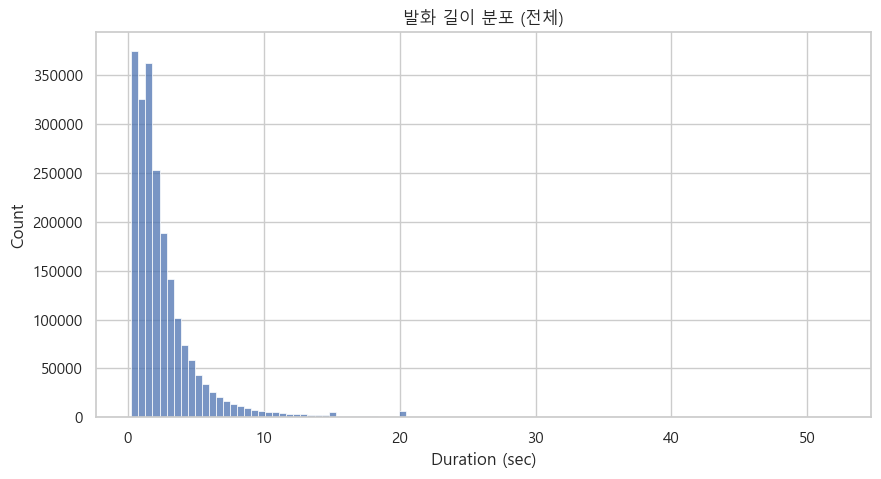

In [17]:
# -----------------------------
# 1. 발화 길이 분포
# -----------------------------
plt.figure(figsize=(10,5))
sns.histplot(df["dur"], bins=100, kde=False)
# plt.xlim(0, 10)   # 긴 꼬리 때문에 잘 안 보이면, 최대 10초까지만 잘라보기
plt.title("발화 길이 분포 (전체)")
plt.xlabel("Duration (sec)")
plt.ylabel("Count")
plt.show()

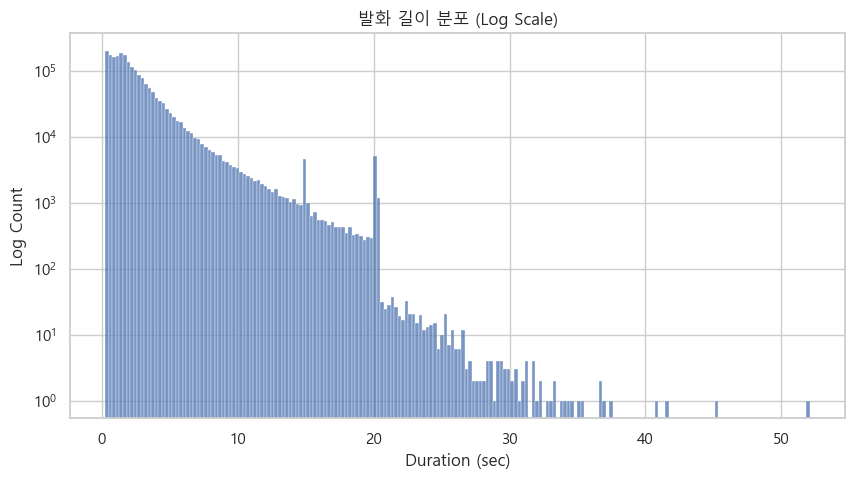

In [18]:
# 로그스케일로 긴 꼬리 확인
plt.figure(figsize=(10,5))
sns.histplot(df["dur"], bins=200, kde=False, log=True)
plt.title("발화 길이 분포 (Log Scale)")
plt.xlabel("Duration (sec)")
plt.ylabel("Log Count")
plt.show()

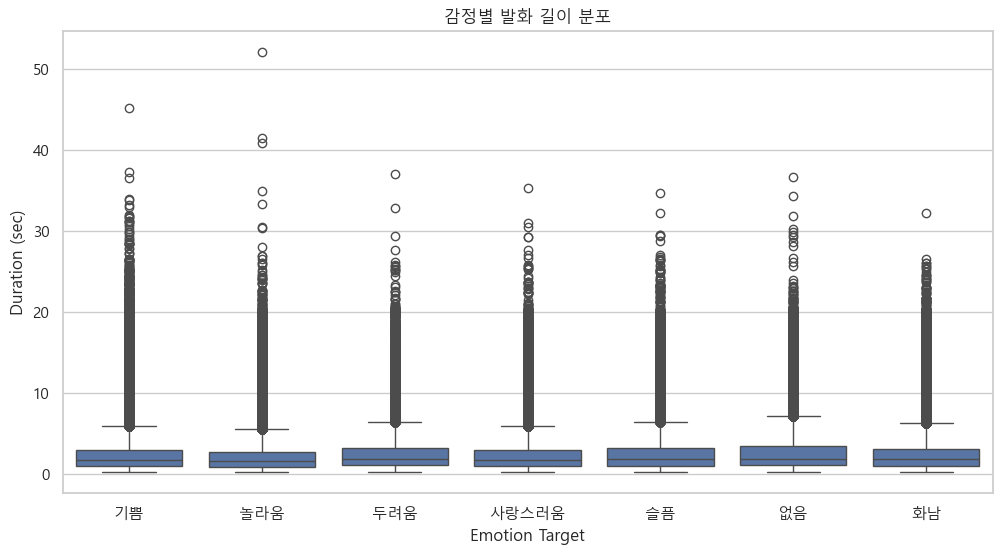

In [19]:
# 감정별 박스플롯
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="VerifyEmotionTarget", y="dur")
plt.title("감정별 발화 길이 분포")
plt.xlabel("Emotion Target")
plt.ylabel("Duration (sec)")
plt.show()

감정 관련

In [23]:
import numpy as np

In [ ]:
# 파일별 감정 비율
file_emotion_counts = df.groupby(["File.FileName","VerifyEmotionTarget"]).size().unstack(fill_value=0)

# 파일별 비율
file_emotion_ratio = file_emotion_counts.div(file_emotion_counts.sum(axis=1), axis=0)

# 파일별 Shannon entropy (감정 다양성 지표)
entropy = - (file_emotion_ratio * np.log2(file_emotion_ratio+1e-9)).sum(axis=1)
df_entropy = entropy.reset_index().rename(columns={0:"entropy"})

# 감정 도배된 파일 확인 (예: 한 감정 비율이 0.8 이상)
dominant_emotion_ratio = file_emotion_ratio.max(axis=1)
biased_files = dominant_emotion_ratio[dominant_emotion_ratio >= 0.7]

print(f"한 감정이 70% 이상 차지하는 파일 수: {len(biased_files)} / {len(file_emotion_ratio)}")
print(biased_files.head())

C:\Users\phoen\AppData\Local\Temp\ipykernel_26840\3860623950.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  file_emotion_counts = df.groupby(["File.FileName","VerifyEmotionTarget"]).size().unstack(fill_value=0)


한 감정이 80% 이상 차지하는 파일 수: 4868 / 8295
File.FileName
2_1312G1A4_1243G2A3_T1_2D09T0400C000213_018255    0.943662
2_1312G1A4_1243G2A3_T1_2D11T0469C000023_005760    0.739130
2_1319G2A2_1307G2A3_T1_2D04T0167C000195_005181    0.969231
2_1319G2A2_1307G2A3_T1_2D04T0171C000001_005175    1.000000
2_1319G2A2_1307G2A3_T1_2D04T0171C000115_005176    0.800000
dtype: float64


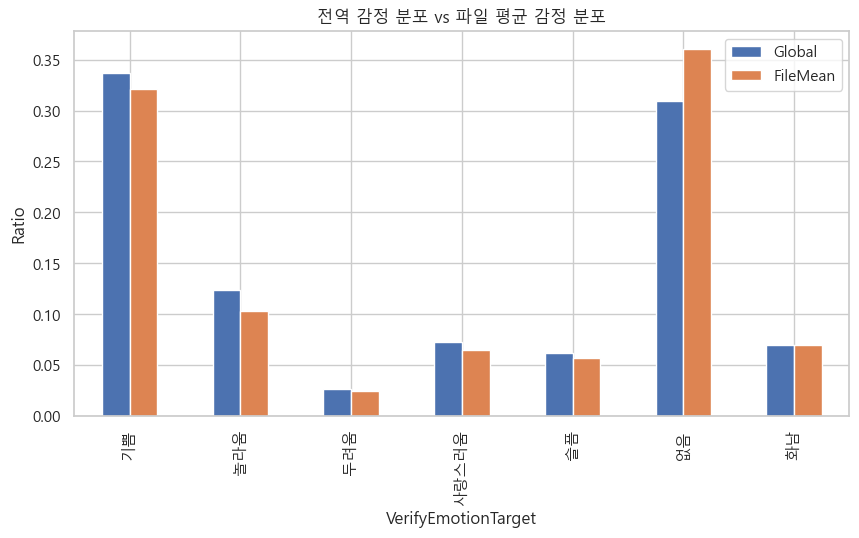

In [26]:
# -----------------------------
# 3. 전역 vs 파일 평균 감정 분포 비교
# -----------------------------
global_dist = df["VerifyEmotionTarget"].value_counts(normalize=True)
file_mean_dist = file_emotion_ratio.mean()

compare_dist = pd.DataFrame({
    "Global": global_dist,
    "FileMean": file_mean_dist
})

compare_dist.plot(kind="bar", figsize=(10,5))
plt.title("전역 감정 분포 vs 파일 평균 감정 분포")
plt.ylabel("Ratio")
plt.show()